In [1]:
# #%pip install -r requirements.txt
# %pip install matplotlib
# %pip install ipywidgets
# %pip install scikit-learn
# %pip install pandas
# %pip install requests
# %pip install seaborn
# %pip install numpy
# %pip install smopy
# %pip install matplotlib
# %pip install scipy
# %pip install folium
# %pip install geopandas matplotlib shapely
# %pip install plotly
# %pip install contextily
# %pip install pystan
# %pip install --upgrade pystan httpstan
# %pip install prophet
# %pip install ipywidgets
# %pip install scikit-learn
# %pip install geopandas
# %pip install joblib
# %pip freeze > requirements.txt


In [1]:
import requests
from IPython.display import GeoJSON
import pandas as pd
import io
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta


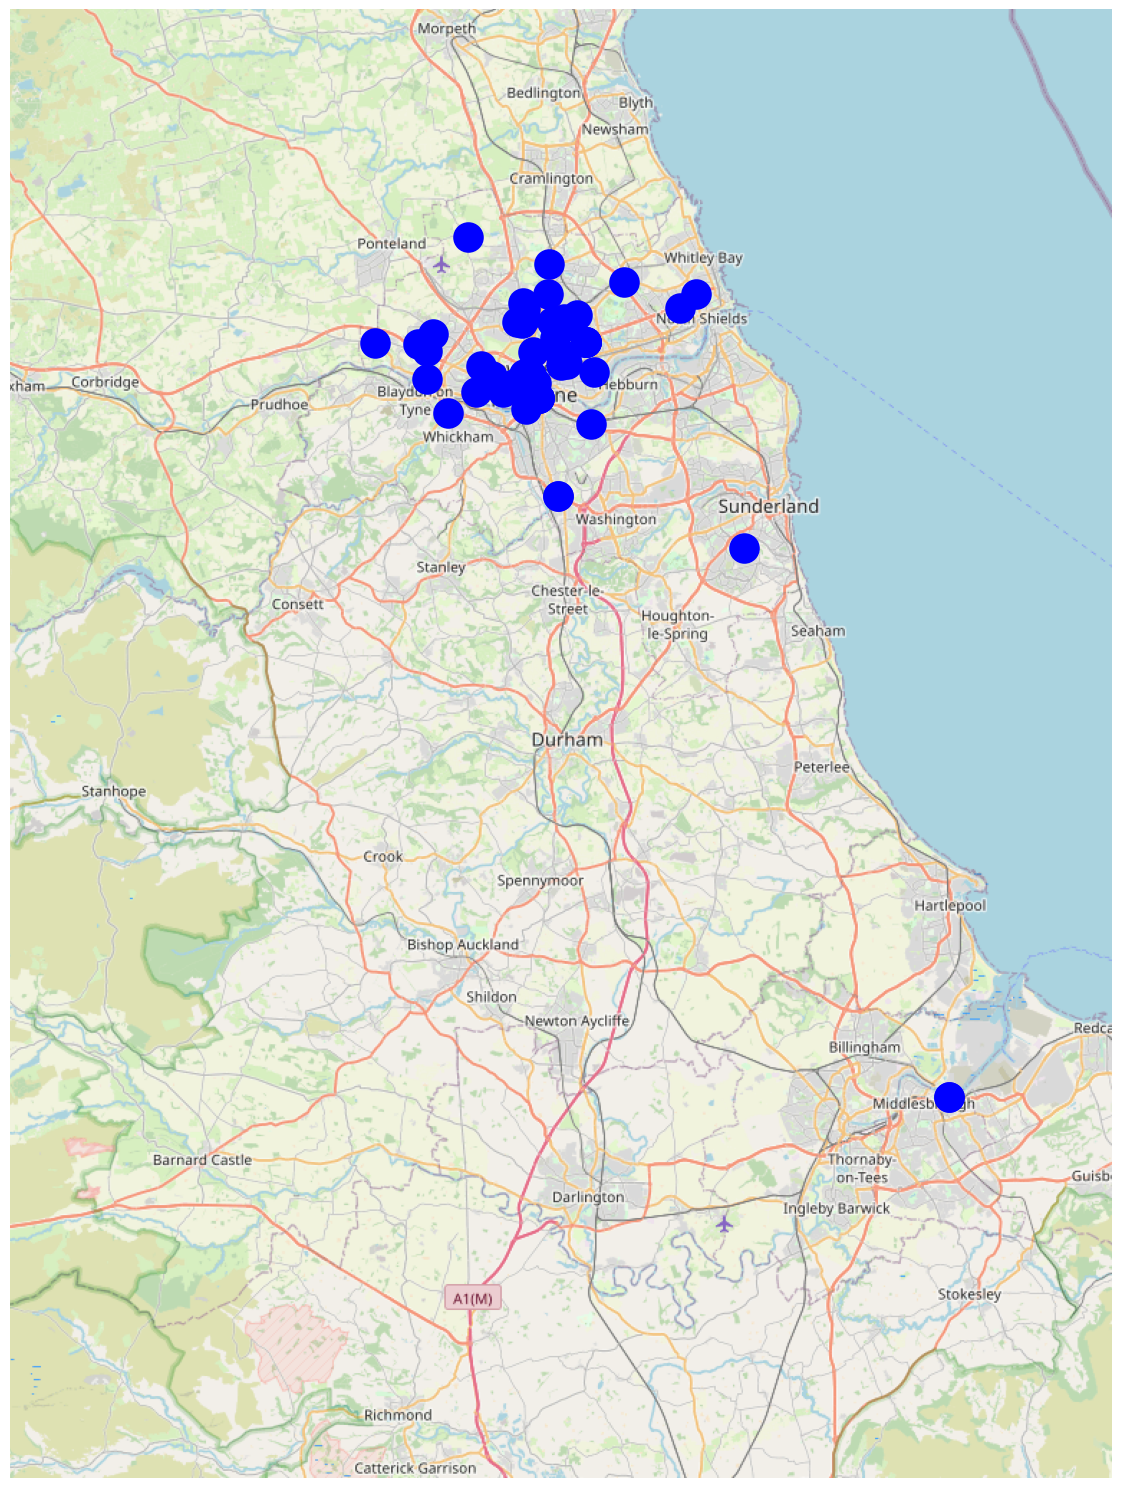

In [2]:
import smopy
import matplotlib.patheffects as pe

sensor_params_pm2 = dict(
    sensor_type='PM2.5')

sensor_params_pm10 = dict(
    sensor_type='PM10')

sensor_params_no2 = dict(
    sensor_type='NO2')

def create_map(sensor_params):
    r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/csv/',sensor_params)

    sensor_info = pd.read_csv(io.StringIO(r.text) )
    sensor_info
    
    bbox = (
    min(sensor_info['Sensor Centroid Latitude']),
        min(sensor_info['Sensor Centroid Longitude']),
        max(sensor_info['Sensor Centroid Latitude']),
        max(sensor_info['Sensor Centroid Longitude']),
    )

    map = smopy.Map(bbox, z=10)
    ax = map.show_mpl(figsize=(15, 15))
    for i,row in sensor_info.iterrows():
        x, y = map.to_pixels(row['Sensor Centroid Latitude'], row['Sensor Centroid Longitude'])
        ax.plot(x, y, 'ob', ms=20, mew=2);
        
        
create_map(sensor_params_pm2)

In [3]:
import os
from pathlib import Path

class AggData:
    instances = []
    data_params = {}
    df = pd.DataFrame()
    df_downsampled = pd.DataFrame()
    downsampled = False
    days=0
    units=""
    
    
    def __init__(self, variable, _days=1):
        self.days=_days

        self.data_params = dict(
            data_variable=variable,
            agg_method='median',
            agg_period='15mins',
            starttime=(datetime.now() - timedelta(days=_days)).strftime("%Y%m%d%H%M%S"),
            endtime=datetime.now().strftime("%Y%m%d%H%M%S"),
            sensor_type=variable
        )

        self.df = self.fetch_agg_data(self.data_params)
        
        try:
            self.units = self.df["Units"].iloc[0]  # Set units attribute
        except KeyError:
            print("Units column not found in DataFrame. Setting self.units to an empty string.")
            self.units = ""
        except IndexError:
            print("Units column is empty. Setting self.units to an empty string.")
            self.units = ""

        
        self.df_downsampled = self.df
        AggData.instances.append(self)


    def fetch_agg_data(self, data_params):
        # Set up filename with variable and number of days
        csv_filename = f"{data_params['data_variable']}_{(datetime.now() - datetime.strptime(data_params['starttime'], '%Y%m%d%H%M%S')).days}_days.csv"
        csv_path = Path(csv_filename)

        try:
            # Attempt to fetch data from API
            r = requests.get('http://uoweb3.ncl.ac.uk/api/v1.1/sensors/data/agg/csv/', data_params)
            
            # If site down for maintenance, catch
            if r.text.startswith("<!doctype html>\n<title>Site Maintenance</title>"):
                raise Exception("Maintenance")
            else:
                # Else set up dataframe and update csv
                df = pd.read_csv(io.StringIO(r.text))
                df.to_csv(csv_path, index=False)
                return df
        except Exception as e:
            # If site down for maintenance, attempot to load most recent csv
            if csv_path.exists():
                print(f"Loading data from {csv_path} due to API error: {e}")
                df = pd.read_csv(csv_path)
                return df
            else:
                raise Exception("Data not available due to API error and no local CSV file found.")

    def downsample(self):
        days=self.days
        if self.downsampled:
            print("Data is already downsampled.")
            return

        # Set target frequency based on the number of days
        target_frequency = self.get_target_frequency(days)

        # Resample the data
        self.df_downsampled['Timestamp'] = pd.to_datetime(self.df_downsampled['Timestamp'])
        self.df_downsampled.set_index('Timestamp', inplace=True)
        df_resampled = self.df_downsampled['Value'].resample(target_frequency).mean()
        df_resampled = df_resampled.to_frame().reset_index()
        df_resampled = pd.merge(df_resampled, self.df_downsampled.drop('Value', axis=1), on='Timestamp')

        # Update the object attributes
        self.df_downsampled = df_resampled
        # self.downsampled = True
        self.target_frequency = target_frequency
        print(f"Data has been downsampled to {target_frequency} resolution.")

    def get_target_frequency(self, days):
        if days == 1:
            return '15min'
        elif days == 3:
            return '1H'
        elif days == 7:
            return '2H'
        else:
            return '6H'

    def get_mean_average(self):
        return self.df['Value'].mean()

    def __str__(self):
        return f"{self.data_params['data_variable']}"
    


In [4]:
def Remove_Suspect(df):
    
    # Drop rows containing NaN values
    df.dropna(inplace=True)

    # Remove rows with 'Value' <= 0
    df = df[df['Value'] > 0]

    # Remove flagged as suspect readings
    df = df[df['Flagged as Suspect Reading'] == False]

    return df


def Remove_Outlier_Indices(df):
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList


def iqr_method(df):
    
    nonOutliers = Remove_Outlier_Indices(df['Value'])

    # Non-Outlier Subset of the Given Dataset
    dfIQR = df[nonOutliers]
    return dfIQR



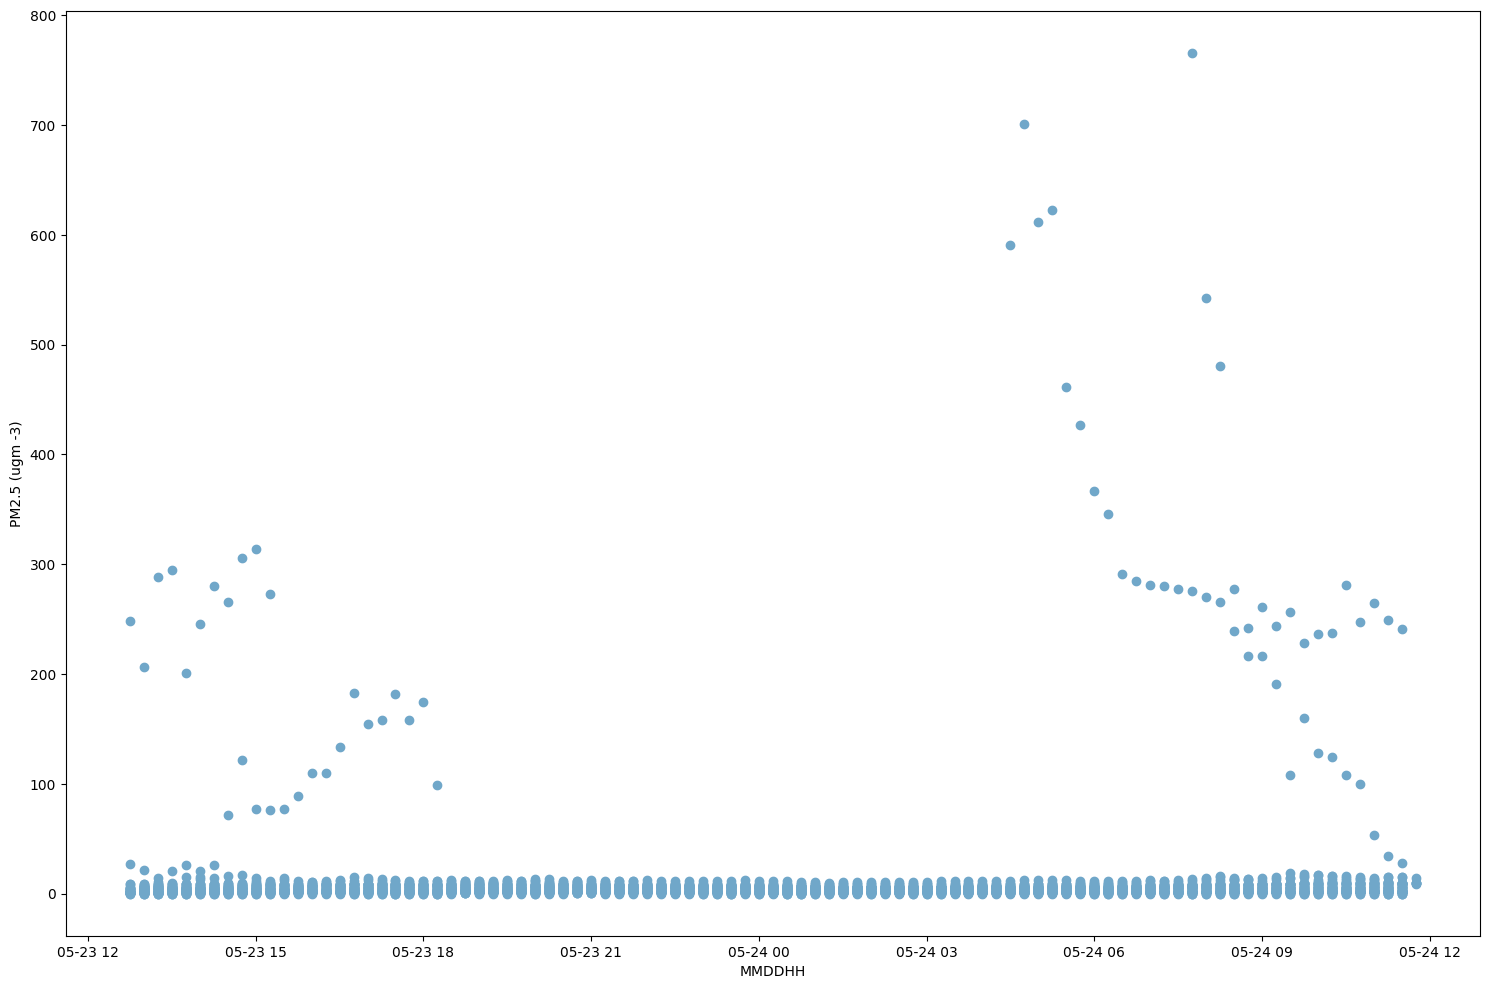

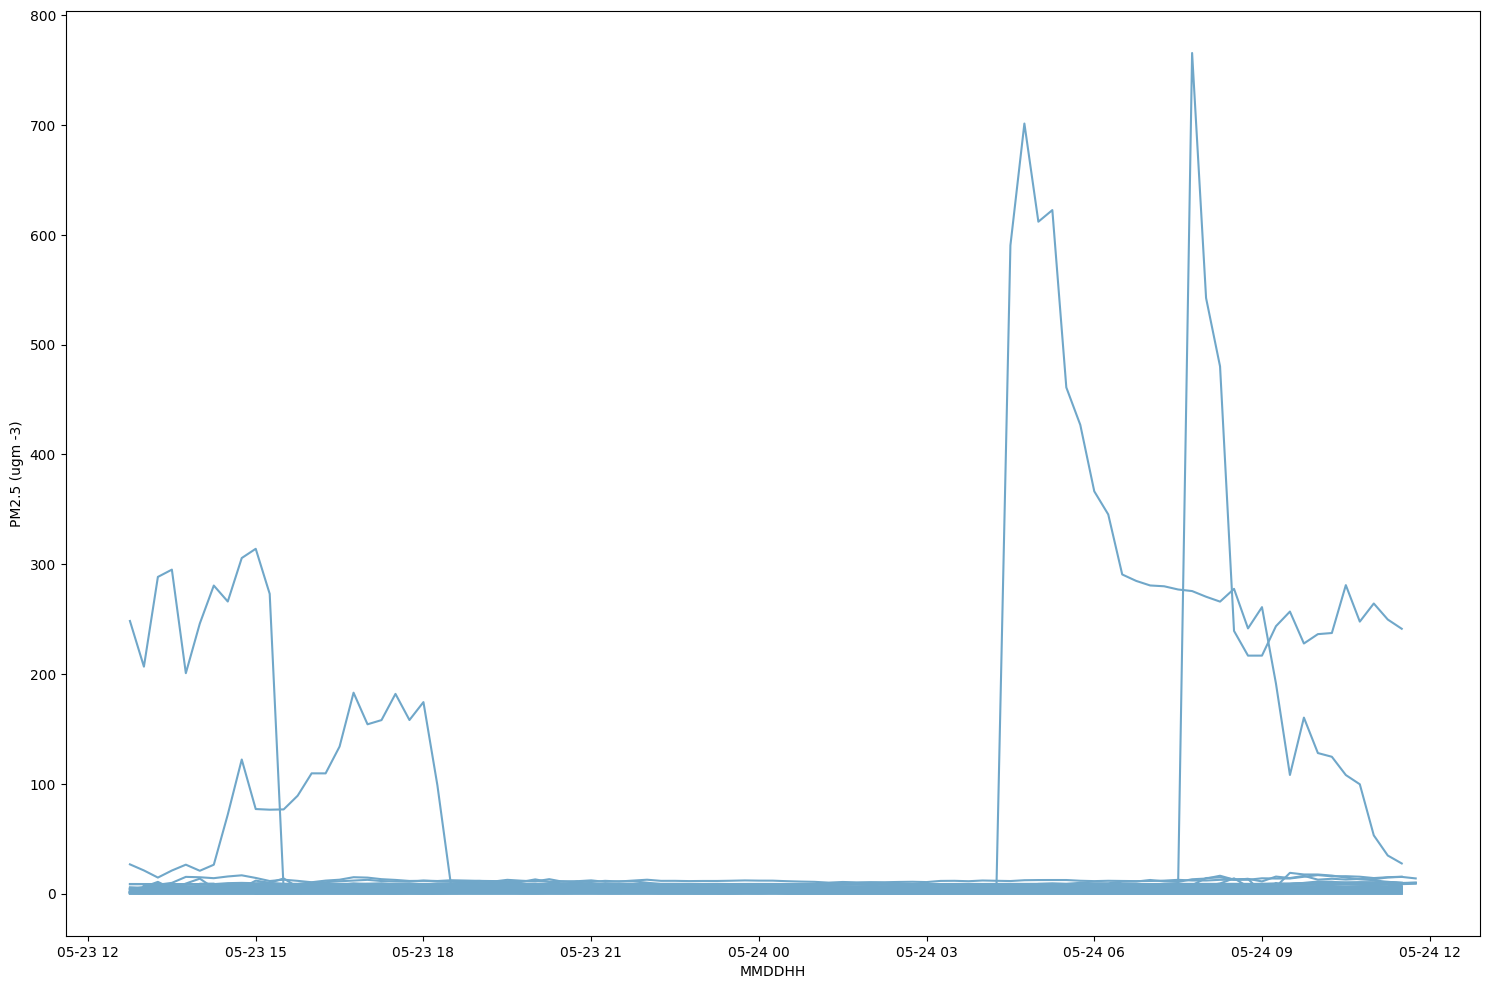

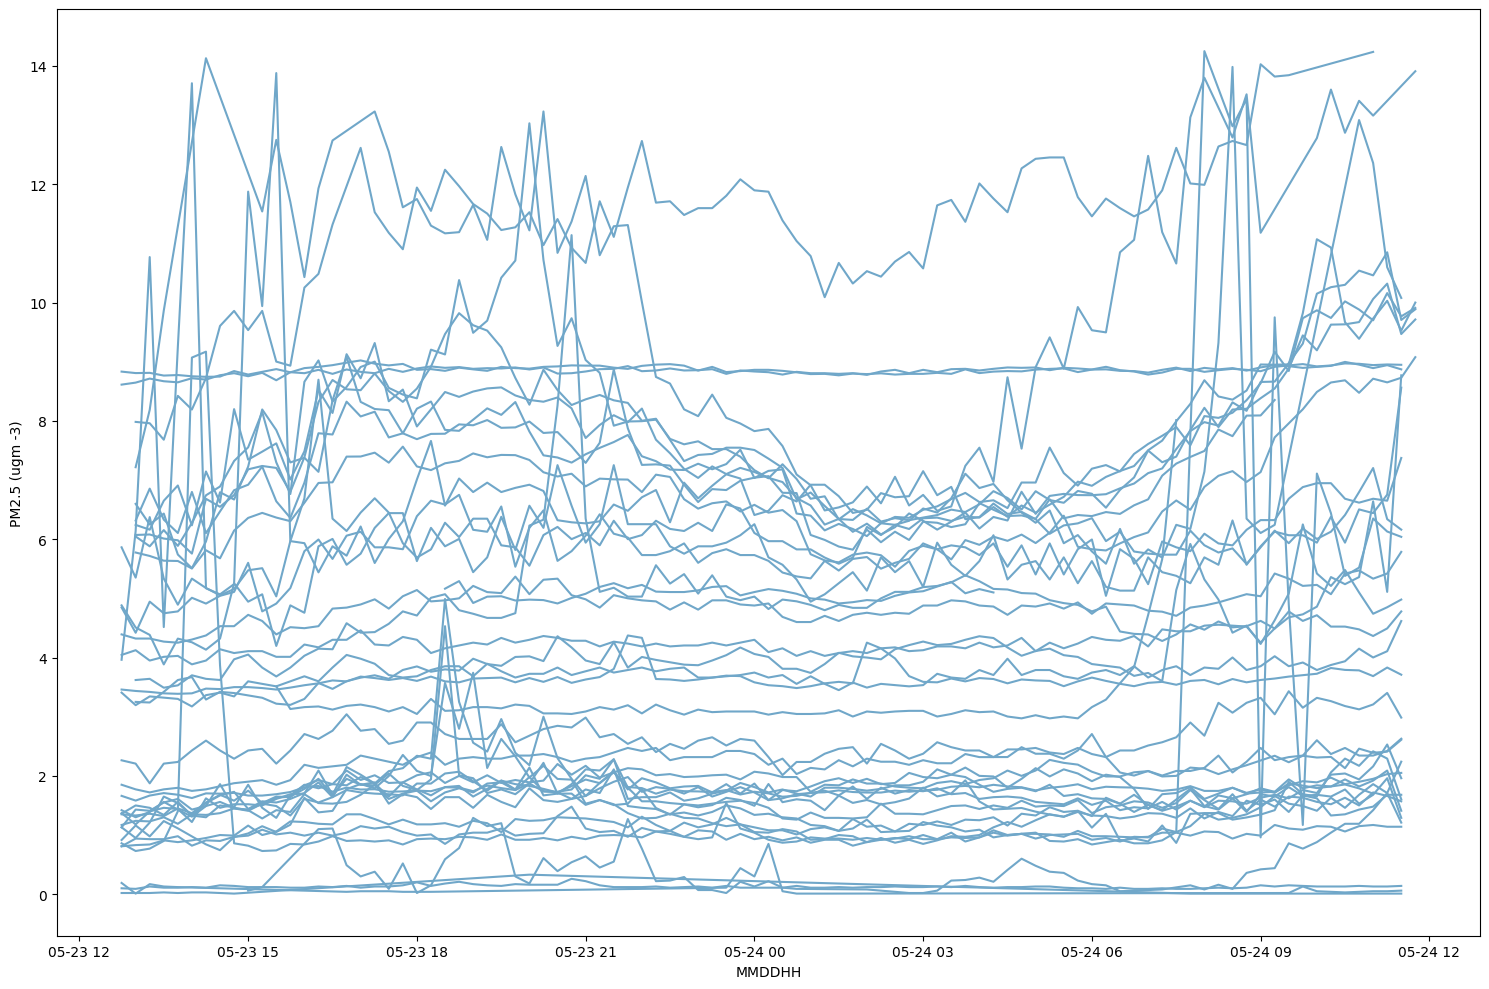

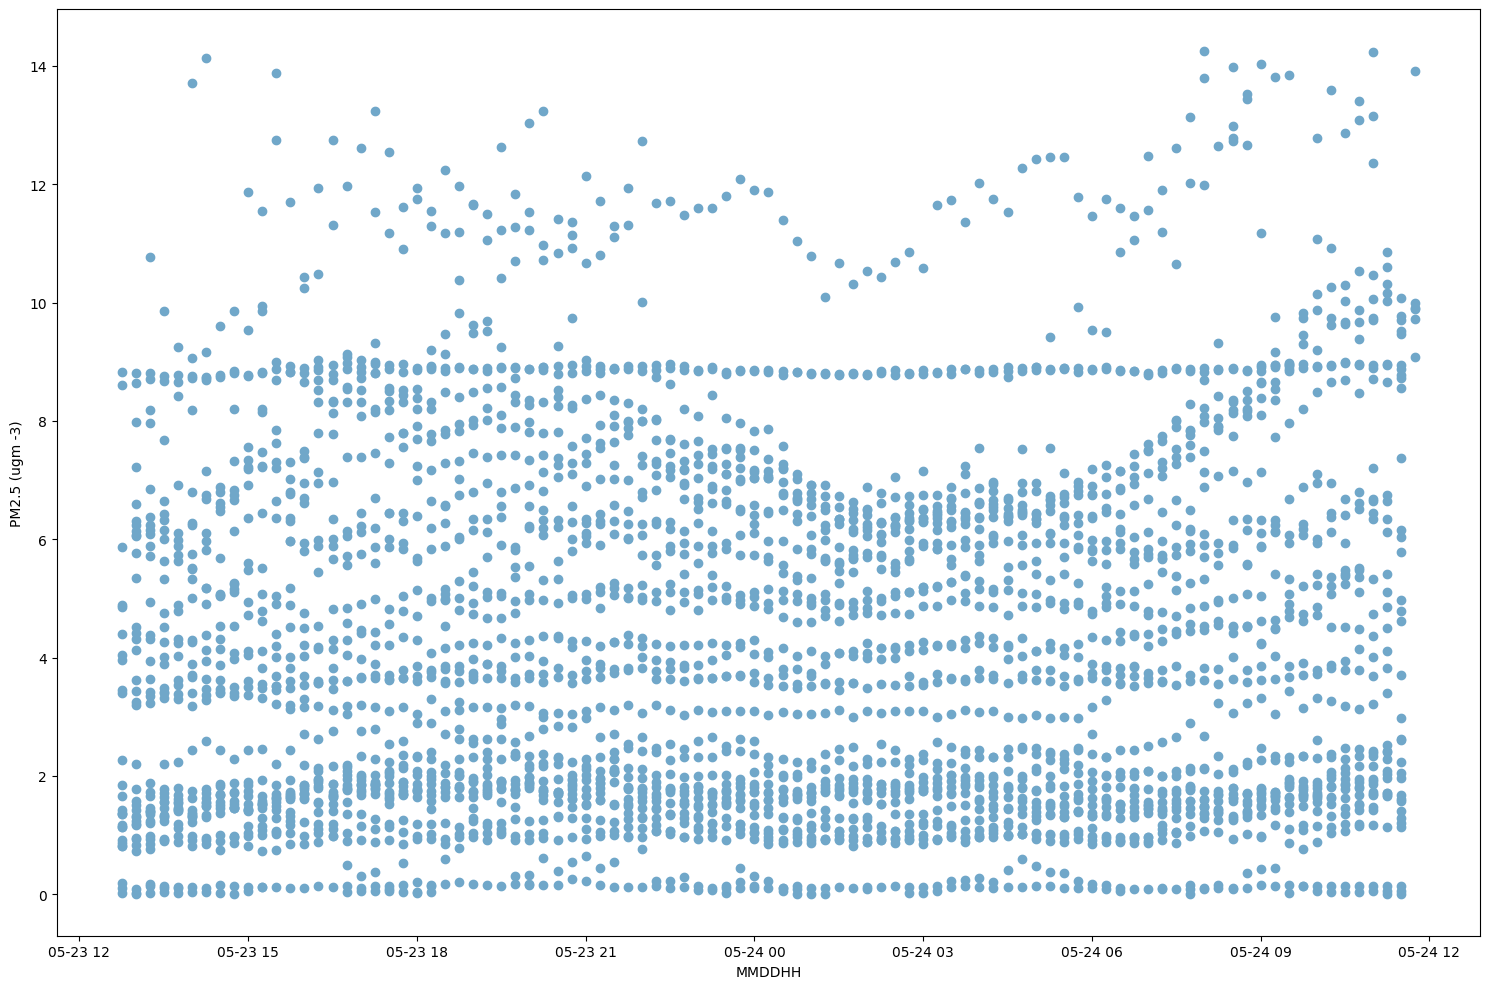

In [5]:
from matplotlib import pyplot as plt
def plot_line_graph(df, aggdata_instance, ax=None, figsize=(15, 10)):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    for sensor_name, sensor_data in df.groupby('Sensor Name'):
        datetimes = pd.to_datetime(sensor_data['Timestamp'])
        ax.plot(datetimes, sensor_data['Value'], color='#70A7C9')  # Set color to blue and remove label
#FF7F50
        ax.set_xlabel("MMDDHH")
        # Add units to the y-axis label
        ylabel = f"{aggdata_instance.data_params['data_variable']} ({aggdata_instance.units})"
        ax.set_ylabel(ylabel)
        
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=10) 
    plt.tight_layout()

def plot_scatter_graph(df, aggdata_instance, ax=None, figsize=(15, 10)):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    for sensor_name, sensor_data in df.groupby('Sensor Name'):
        datetimes = pd.to_datetime(sensor_data['Timestamp'])
        ax.scatter(datetimes, sensor_data['Value'], color='#70A7C9') 

        ##2B8CBE
        #AED9E0.
        ax.set_xlabel("MMDDHH")
        # Add units to the y-axis label
        ylabel = f"{aggdata_instance.data_params['data_variable']} ({aggdata_instance.units})"
        ax.set_ylabel(ylabel)
        
    plt.tight_layout()

    
a = AggData("PM2.5", 1)

df = a.df  # Get the dataframe from the AggData instance
df = Remove_Suspect(df)  # Pass the dataframe to the Remove_Suspect() function
plot_scatter_graph(df,a)
plot_line_graph(df, a)
df = iqr_method(df)
plot_line_graph(df, a)
plot_scatter_graph(df,a)

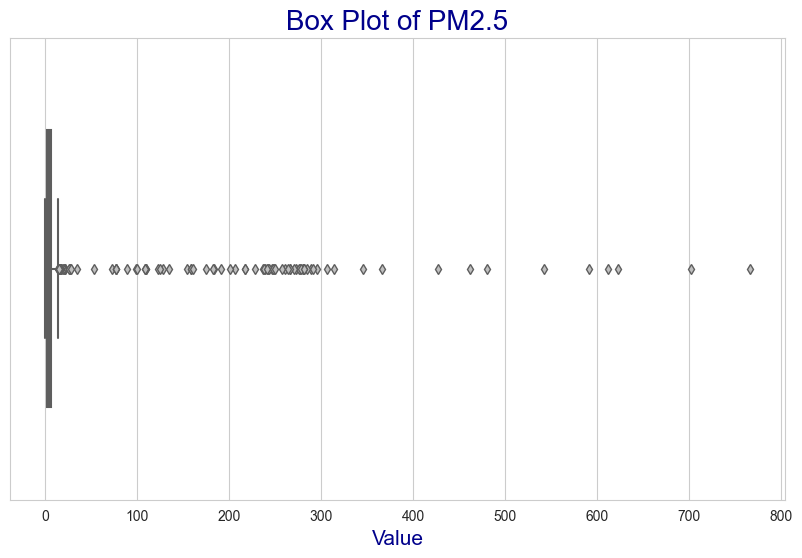

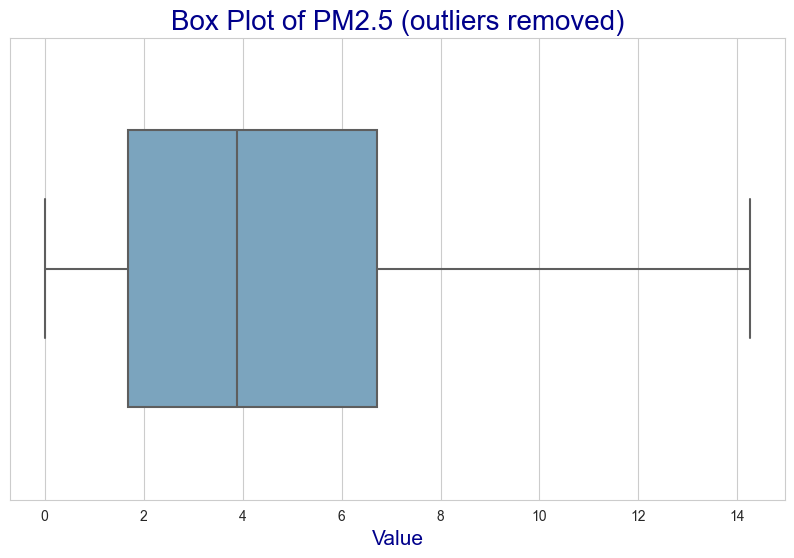

<Figure size 1000x600 with 0 Axes>

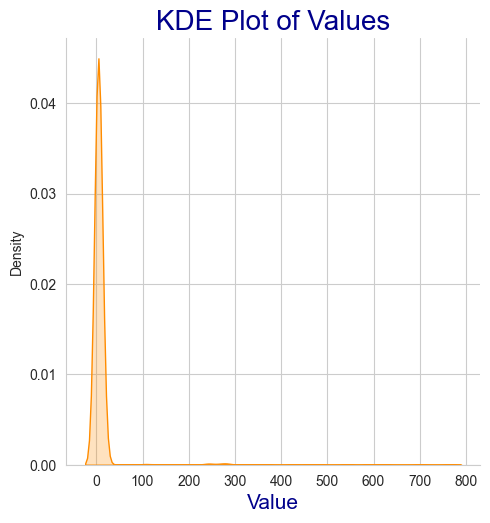

<Figure size 1000x600 with 0 Axes>

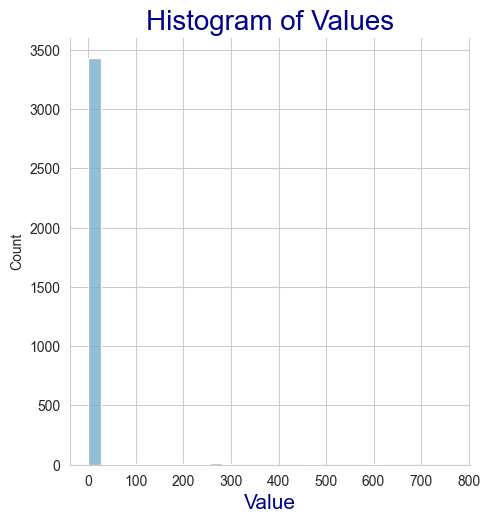

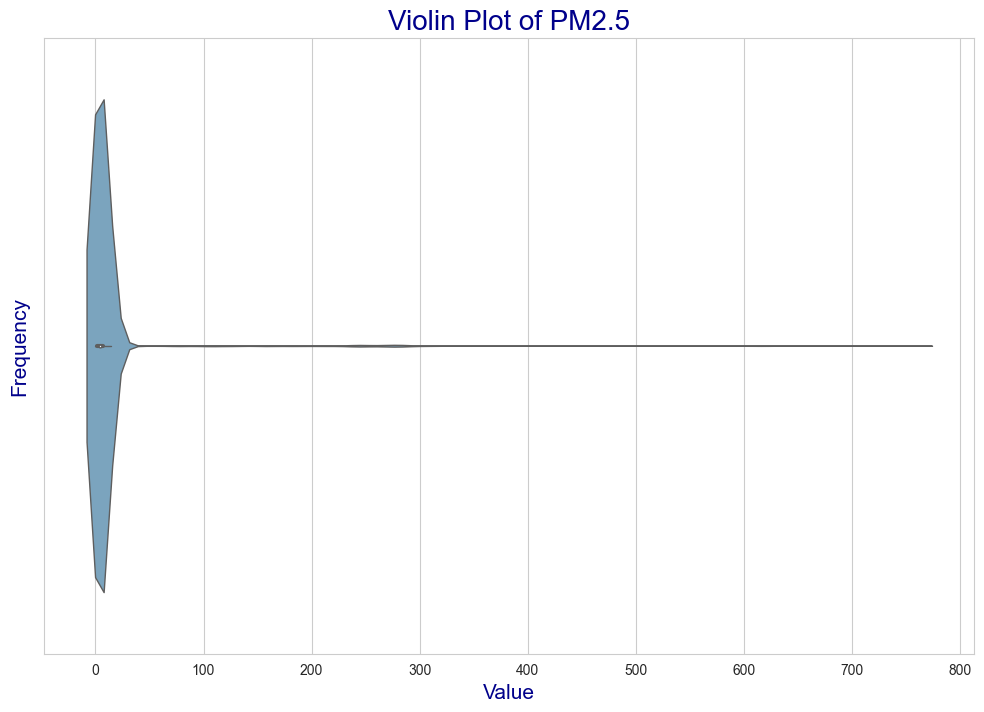

In [6]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

def distribution_plots(df, data_params):
    sns.set_style("whitegrid")
    
    # Box plot with outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Value'], width=0.6, color="#70A7C9", flierprops=dict(markerfacecolor='0.75', markersize=5, linestyle='none'))
    plt.title(f'Box Plot of {data_params["data_variable"]}', size=20, color="darkblue")
    plt.xlabel('Value', size=15, color="darkblue")
    plt.show()

    # Box plot without outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['Value'], width=0.6, color="#70A7C9", showfliers=False)
    plt.title(f'Box Plot of {data_params["data_variable"]} (outliers removed)', size=20, color="darkblue")
    plt.xlabel('Value', size=15, color="darkblue")
    plt.show()

    # kde plot
    plt.figure(figsize=(10, 6))
    sns.displot(data=df, x=df['Value'], kind="kde", color="darkorange", fill=True)
    plt.title('KDE Plot of Values', size=20, color="darkblue")
    plt.xlabel('Value', size=15, color="darkblue")
    plt.show()
    
    # Histogram plot
    plt.figure(figsize=(10, 6))
    sns.displot(data=df, x=df['Value'], color="#70A7C9", bins=30)
    plt.title('Histogram of Values', size=20, color="darkblue")
    plt.xlabel('Value', size=15, color="darkblue")
    plt.show()

    # Violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(x=df['Value'], palette=["#70A7C9", "darkorange"], bw=.2, cut=1, linewidth=1)
    plt.title(f'Violin Plot of {data_params["data_variable"]}', size=20, color="darkblue")
    plt.xlabel('Value', size=15, color="darkblue")
    plt.ylabel('Frequency', size=15, color="darkblue")
    plt.show()

    
a = AggData("PM2.5", 1)
df = a.df  # Get the dataframe from the AggData instance
df = Remove_Suspect(df)  # Pass the dataframe to the Remove_Suspect() function
distribution_plots(df, a.data_params)

Logarithm


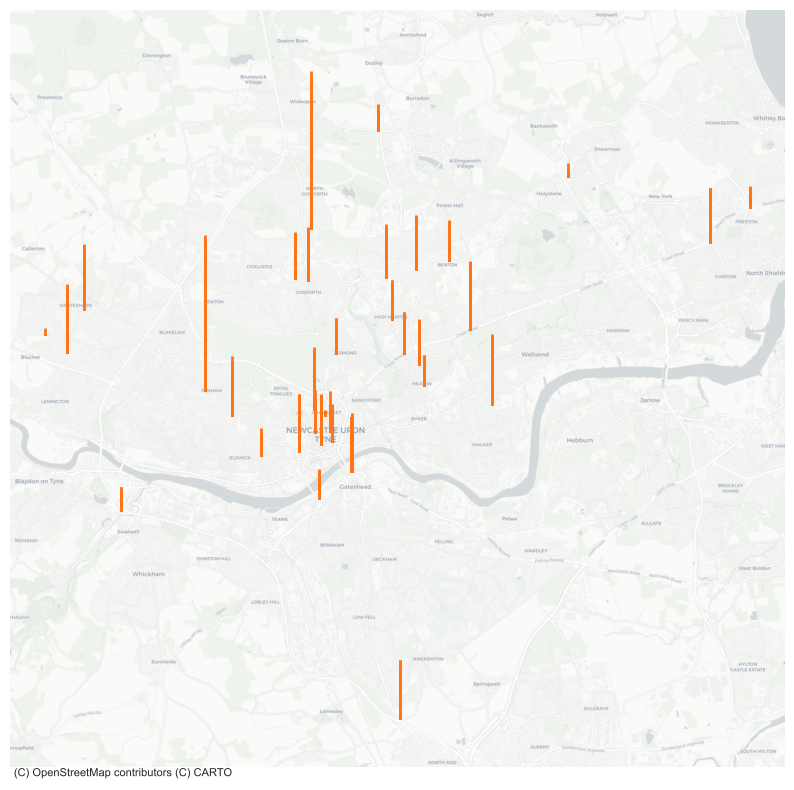

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import numpy as np
import contextily as ctx

def plot_sensor_spikes(df, scale_factor=100):
    scale_factor = scale_factor*10
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Sensor Centroid Longitude'], df['Sensor Centroid Latitude']))

    # Set CRS for the GeoDataFrame
    gdf = gdf.set_crs("EPSG:4326")
    gdf = gdf.to_crs("EPSG:3857")

    # Set all angles to 0 degrees (up)
    gdf['angle'] = 0

    # Create the create_spike function as before, but set the angle to 0 degrees (up)
    def create_spike(row, scale_factor):
        centroid = row.geometry.centroid

        # Apply the log transformation to the 'Value' column
        # Use np.log1p to compute the natural logarithm of one plus the input array, element-wise
        # This function provides greater precision for small input values
        spike_length = np.log1p(row['Value']) * scale_factor

        angle = 0  # Set the angle to 0 degrees (up)

        end_y = centroid.y + spike_length * np.cos(np.deg2rad(angle))
        end_x = centroid.x + spike_length * np.sin(np.deg2rad(angle))
        spike_line = LineString([(centroid.x, centroid.y), (end_x, end_y)])

        return spike_line

    # Create a copy of the GeoDataFrame and apply the create_spike function
    gdf_spikes = gdf.copy()
    gdf_spikes['geometry'] = gdf.apply(create_spike, scale_factor=scale_factor, axis=1)

    # Plot the spikes on the map
    fig, ax = plt.subplots(figsize=(10, 10))
    # gdf.geometry.plot(ax=ax, markersize=10, color='blue')  # Sensor locations dots
    gdf_spikes.plot(ax=ax, linewidth=2, color='#FF7518')
    plt.axis('equal')  # Set equal aspect ratio

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    print("Logarithm")
    plt.show()
    

df1 = Remove_Suspect(AggData("PM2.5").df)
gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1['Sensor Centroid Longitude'], df1['Sensor Centroid Latitude']))
plot_sensor_spikes(gdf)



In [8]:
import folium
from joblib import Parallel, delayed
from scipy.stats.mstats import winsorize
from branca.colormap import linear, LinearColormap
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np

def create_spike(row, scale_factor):
    centroid = row.geometry.centroid
    spike_length = row['Value'] * scale_factor
    angle = 0  # Set the angle to 0 degrees (up)

    end_y = centroid.y + spike_length * np.cos(np.deg2rad(angle))
    end_x = centroid.x + spike_length * np.sin(np.deg2rad(angle))
    spike_line = LineString([(centroid.x, centroid.y), (end_x, end_y)])

    # Convert the spike's coordinates from Web Mercator to WGS84
    spike_wgs84 = gpd.GeoSeries(spike_line, crs="EPSG:3857").to_crs("EPSG:4326").iloc[0]

    # Calculate the coordinates for the top of the spike
    top_coords = [spike_wgs84.coords[1][0], spike_wgs84.coords[1][1]]

    # Return a GeoJSON Feature for the spike
    return {
        "type": "Feature",
        "properties": {
            "Value": row["Value"],
            "TopCoords": top_coords  # Include the top coordinates in the properties
        },
        "geometry": {
            "type": "LineString",
            "coordinates": [
                [spike_wgs84.coords[0][0], spike_wgs84.coords[0][1]],  # Start of the line (base of the spike)
                [spike_wgs84.coords[1][0], spike_wgs84.coords[1][1]]   # End of the line (tip of the spike)
            ]
        }
    }

def create_sensor_spike_map_folium(gdf, location=[54.9714, -1.6174], zoom_start=12, scale_factor=100):

    # Create an empty Folium Map object centered at Newcastle upon Tyne
    m = folium.Map(
        location=location,
        zoom_start=zoom_start,
        tiles='cartodbpositron',
        control_scale=True,
        prefer_canvas=True,
        background_color='black',
        fill_color='rgba(0, 0, 0, 0.2)'
    )

    # Set CRS for the GeoDataFrame
    gdf = gdf.set_crs("EPSG:4326", allow_override=True)
    gdf = gdf.to_crs("EPSG:3857")

    # Filter out rows with missing values
    gdf_filtered = gdf.dropna(subset=['Value'])

    # Winsorize the 'Value' column
    gdf_filtered['Value'] = winsorize(gdf_filtered['Value'], limits=[0.05, 0.05])

    gdf_filtered['geometry'] = gdf.geometry.buffer(0.001)

    # Create a colormap for the 'Value' column
    colormap = linear.Oranges_09.scale(gdf_filtered['Value'].min(), gdf_filtered['Value'].max())
    colormap.caption = 'Values'  # Set the legend label here
    
    # Parallelize the spike creation
    n_jobs = -1  # Use all available cores
    spikes = Parallel(n_jobs=n_jobs)(delayed(create_spike)(row, scale_factor) for index, row in gdf_filtered.iterrows())

    # Add the spikes to the map as GeoJSON
    folium.GeoJson(
        data={
            "type": "FeatureCollection",
            "features": spikes
        },
        style_function=lambda feature: {
            "color": colormap(feature["properties"]["Value"]),
            "weight": 2.5,
            "opacity": 0.8,
        },
        tooltip=folium.GeoJsonTooltip(
            fields=["Value"],
            aliases=["Top Value"],
            localize=True
        )
    ).add_to(m)
    
    colormap.add_to(m)
    
    return m


create_sensor_spike_map_folium(gdf)

12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing


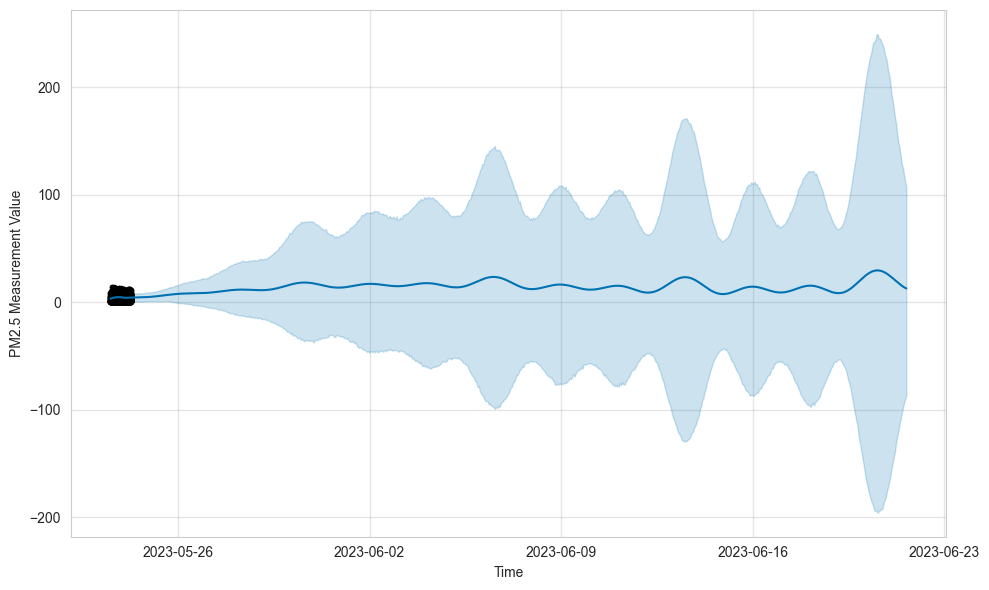

Mean Absolute Error: 9.57
9.571509650329443


In [9]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

def prophet_forecast(input_df):
    # Clean and prepare the data
    df = Remove_Suspect(input_df.df)
    df = iqr_method(df)
    # Select relevant columns and rename them as required by Prophet
    df = df[['Timestamp', 'Value']]
    df.columns = ['ds', 'y']

    # Make sure the 'ds' column is in datetime format
    df['ds'] = pd.to_datetime(df['ds'])

    # Split the data into train and test sets (80% train, 20% test)
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]

    # Initialize and fit the Prophet model with tuned hyperparameters
    model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5, yearly_seasonality=10, weekly_seasonality=True)
    model.fit(train_df)

    # Make predictions for the test set
    future = model.make_future_dataframe(periods=len(test_df), freq='H')
    forecast = model.predict(future)

    # Plot the predictions
    fig = model.plot(forecast)

    # Set the Y-axis label
    ax = fig.gca()
    ax.set_ylabel(str(input_df) +' Measurement Value')

    # Optionally, you can set the X-axis label as well
    ax.set_xlabel('Time')

    plt.show()

    # Calculate the Mean Absolute Error (MAE) to evaluate the model's performance
    mae = mean_absolute_error(test_df['y'], forecast['yhat'].tail(len(test_df)))
    print(f"Mean Absolute Error: {mae:.2f}")

    return mae


df=AggData("PM2.5")

print(prophet_forecast(df))


In [10]:

import plotly.graph_objects as go

def create_gauge(variable, value):
    
    
    # Red start value at unsafe values
    if variable == 'PM2.5':
        max_value = 105
        red_start = 35
    elif variable == 'NO2':
        max_value = 75
        red_start = 25
    elif variable == 'PM10':
        max_value = 135
        red_start = 45
        
    else:
        raise ValueError("Invalid variable specified")

    

    gauge = go.Figure(go.Indicator(
        mode="gauge+number",
        value=value,
        domain={'x': [0, 1], 'y': [0, 1]},
        title={'text': f"{variable}", 'font': {'size': 22}},
        gauge={
            'axis': {'range': [0, max_value], 'tickwidth': 1, 'tickcolor': "black"},
            'bar': {'color': "black"},
            'bgcolor': "white",
            'borderwidth': 0,
            'bordercolor': "white",
            'steps': [
                {'range': [0, red_start], 'color': '#70A7C9'},
                {'range': [red_start, max_value], 'color': '#FF8C00'}
            ],
        }
    ))
    
    # Set the size and margins of the gauge chart
    gauge.update_layout(
        width=300,
        height=300,
        margin=dict(l=20, r=20, t=20, b=20)
    )

    gauge.update_layout(autosize=True)
    return gauge

df=AggData("PM2.5")
pm25_gauge = create_gauge("PM2.5", df.get_mean_average())

In [11]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

def plot_choropleth(gdf):
    merged_gdf = gdf
    # Set CRS for the merged GeoDataFrame
    merged_gdf = merged_gdf.set_crs("EPSG:4326")
    merged_gdf = merged_gdf.to_crs("EPSG:3857")

    # Plot the choropleth map
    fig, ax = plt.subplots(figsize=(10, 10))
    merged_gdf.plot(column='Value', cmap='plasma', legend=True, ax=ax)
    plt.axis('equal')  # Set equal aspect ratio

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()

    plt.show()
    
# dfIQR1 = iqr_method(Remove_Suspect(AggData("PM2.5").df))
# df1 = Remove_Suspect(AggData("PM2.5").df)
# gdf = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1['Sensor Centroid Longitude'], df1['Sensor Centroid Latitude']))
# plot_choropleth(gdf)

In [12]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:65% !important; }</style>"))

In [13]:

def create_spinner():
    spinner = widgets.HTML("""
        <div style="display: flex; justify-content: center;">
            <div class="lds-ring"><div></div><div></div><div></div><div></div></div>
        </div>
        <style>
        .lds-ring {
          display: inline-block;
          position: relative;
          width: 80px;
          height: 80px;
        }
        .lds-ring div {
          box-sizing: border-box;
          display: block;
          position: absolute;
          width: 64px;
          height: 64px;
          margin: 8px;
          border: 8px solid #5bc0de;
          border-radius: 50%;
          animation: lds-ring 1.2s cubic-bezier(0.5, 0, 0.5, 1) infinite;
          border-color: #5bc0de transparent transparent transparent;
        }
        .lds-ring div:nth-child(1) {
          animation-delay: -0.45s;
        }
        .lds-ring div:nth-child(2) {
          animation-delay: -0.3s;
        }
        .lds-ring div:nth-child(3) {
          animation-delay: -0.15s;
        }
        @keyframes lds-ring {
          0% {
            transform: rotate(0deg);
          }
          100% {
            transform: rotate(360deg);
          }
        }
        </style>
    """)
    return spinner

In [14]:

from ipywidgets import interactive, Layout, widgets
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

def plot_line_graph_tab(var1, var2, remove_outliers):
    with line_graph_output:
        clear_output(wait=True)
        
        # Remove suspects and perform IQR if needed
        if remove_outliers:
            var1.df_downsampled = iqr_method(Remove_Suspect(var1.df))
            var2.df_downsampled = iqr_method(Remove_Suspect(var2.df))
            print("Outliers Removed")
        else:
            var1.df_downsampled = Remove_Suspect(var1.df)
            var2.df_downsampled = Remove_Suspect(var2.df)
            print("Outliers Included")
        
        # Downsample the data
        if not var1.downsampled:
            var1.downsample()
        if not var2.downsampled:
            var2.downsample()
            
        print("Downsampled")
        # Plot the line graphs
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
        plot_scatter_graph(var1.df_downsampled, var1, ax=ax1)
        plot_scatter_graph(var2.df_downsampled, var2, ax=ax2)
        plt.show()


        
def plot_kde_plot_tab(var1, remove_outliers):
    with kde_plot_output:
        kde_plot_output.clear_output(wait=True)
        df1 = Remove_Suspect(var1.df)
        
        if remove_outliers:
            df1 = iqr_method(df1)
        print("Outliers Removed:" if remove_outliers else "Outliers Included:")
        
        

def plot_distribution_analysis_tab(var1, remove_outliers):
    with distribution_analysis_output:
        clear_output(wait=True)
        
        df1 = Remove_Suspect(var1.df)
        if remove_outliers:
            df1 = iqr_method(df1)
            
        print("Outliers Removed:" if remove_outliers else "Outliers Included:")

        distribution_plots(df1, var1.data_params)
        plt.show()

        

def plot_sensor_spike_map_tab(var1, scale_factor):
    # FOLIUM
    with sensor_spike_map_output:
        sensor_spike_map_output.clear_output()
        df1 = Remove_Suspect(var1.df)
        
        # Group by 'Sensor Centroid Latitude' and 'Sensor Centroid Longitude', and take the maximum 'Value'
        df_max = df1.groupby(['Sensor Centroid Latitude', 'Sensor Centroid Longitude'])['Value'].max().reset_index()

        # Convert the DataFrame to a GeoDataFrame
        gdf_max = gpd.GeoDataFrame(df_max, geometry=gpd.points_from_xy(df_max['Sensor Centroid Longitude'], df_max['Sensor Centroid Latitude']))
        
        sensor_spike_map = create_sensor_spike_map_folium(gdf_max, location=[54.9714, -1.6174], zoom_start=12, scale_factor=scale_factor)
        display(sensor_spike_map)



def plot_sensor_map_tab(var1, scale_factor):
    with sensor_map_output:
        sensor_map_output.clear_output()
        a = AggData("PM2.5")
        df1 = Remove_Suspect(var1.df)

        # Group by 'Sensor Centroid Latitude' and 'Sensor Centroid Longitude', and take the maximum 'Value'
        df_max = df1.groupby(['Sensor Centroid Latitude', 'Sensor Centroid Longitude'])['Value'].max().reset_index()

        # Convert the DataFrame to a GeoDataFrame
        gdf_max = gpd.GeoDataFrame(df_max, geometry=gpd.points_from_xy(df_max['Sensor Centroid Longitude'], df_max['Sensor Centroid Latitude']))
        
        plot_sensor_spikes(gdf_max, scale_factor=scale_factor)


def plot_prophet_forecast_tab(var1):
    with prophet_forecast_output:
        prophet_forecast_output.clear_output()
        
        prophet_forecast(var1)
        
def plot_choropleth_tab(var1):
    with choropleth_output:
        choropleth_output.clear_output(wait=True)
        var1.df_downsampled = Remove_Suspect(var1.df)
        var1.downsample()
        gdf = gpd.GeoDataFrame(var1.df_downsampled, geometry=gpd.points_from_xy(var1.df_downsampled['Sensor Centroid Longitude'], var1.df_downsampled['Sensor Centroid Latitude']))
        plot_choropleth(gdf)        

In [16]:
from IPython.display import HTML
from ipywidgets import Tab, VBox, Output, HBox

%matplotlib inline

# Create separate output widgets for each tab
line_graph_output = Output()
distribution_analysis_output = Output()
sensor_spike_map_output = Output()
sensor_map_output = Output()
prophet_forecast_output = Output()
choropleth_output = Output()

# Create the dropdown widgets for selecting the data variables
variable_selector1 = widgets.Dropdown(
    options=['PM2.5', 'PM10', 'O3', 'Humidity', 'Wind Speed'],
    value='PM2.5',
    description='Variable 1:'
)

variable_selector2 = widgets.Dropdown(
    options=['PM2.5', 'PM10', 'O3', 'Humidity', 'Wind Speed'],
    value='O3',
    description='Variable 2:'
)

variable_selector1.options = ['PM2.5', 'PM10', 'O3', 'NO2', 'Humidity', 'Wind Speed', 'CO']
variable_selector2.options = ['PM2.5', 'PM10', 'O3', 'NO2', 'Humidity', 'Wind Speed', 'CO']


remove_outliers_checkbox = widgets.Checkbox(
    value=True,
    description='Remove Outliers',
    disabled=False,
    indent=False
)


def fetch_agg(variable1, _days):
    print(f"Fetching data for variable {variable1} and days {_days}")
    
    # Find the AggData instance with the selected data variables and days
    selected_agg_data1 = None
    
    for instance in AggData.instances:
        if instance.data_params["data_variable"] == variable1 and instance.days==_days:
            selected_agg_data1 = instance
        if selected_agg_data1 is not None:
            break
    
    # If an instance isn't found, create a new one
    if selected_agg_data1 is None:
        selected_agg_data1 = AggData(variable1, _days)
            
    return selected_agg_data1


last_selected_variables = [None, None]

def update_scale_factor(change):
    selected_index = tab_widget.selected_index
    if selected_index == 2:
        spinner = create_spinner()
        display(spinner)
        time.sleep(0.5)  # Add a small delay to make the spinner visible
        selected_agg_data1 = fetch_agg(variable_selector1.value, days_slider.value)
        with sensor_spike_map_output:  # Use the sensor_spike_map_output context to update the plot
            clear_output(wait=True)
            plot_sensor_spike_map_tab(selected_agg_data1, scale_factor_slider.value)
        clear_output(wait=True)
        display(tab_widget)

def update_choropleth_output(change=None, force_update=False):
    selected_agg_data1 = fetch_agg(variable_selector1.value, days_slider.value)
    plot_choropleth_tab(selected_agg_data1)



# Define a function to update the plot output based on the selected tab
def update_plot_output(change=None, force_update=False):
    global last_selected_variables
    selected_index = tab_widget.selected_index
    current_selected_variables = [variable_selector1.value, variable_selector2.value]
    
    if current_selected_variables == last_selected_variables and not force_update:
        return

    last_selected_variables = current_selected_variables

    # Fetch the AggData instances for the selected variables and days
    selected_agg_data1 = fetch_agg(variable_selector1.value, days_slider.value)
    selected_agg_data2 = fetch_agg(variable_selector2.value, days_slider.value)

    # Line Graph
    if selected_index == 0:
        plot_line_graph_tab(selected_agg_data1, selected_agg_data2, remove_outliers_checkbox.value)
    # KDE
    elif selected_index == 1:
        plot_distribution_analysis_tab(selected_agg_data1, remove_outliers_checkbox.value)
    # Sensor Spike
    elif selected_index == 2:
        plot_sensor_spike_map_tab(selected_agg_data1, scale_factor_slider.value)
    # Sensor Map
    elif selected_index == 3:
        plot_sensor_map_tab(selected_agg_data1, scale_factor_slider.value)
    # Prophet
    elif selected_index == 4:
        plot_prophet_forecast_tab(selected_agg_data1)
    elif selected_index == 5:
        plot_choropleth_tab(selected_agg_data1)
    
    
        
def update_plot_output_with_spinner(change=None, force_update=False):    
    # Create and display spinner, update plot and clear 
    print("Updating plot output with spinner")
    spinner = create_spinner()
    display(spinner)
    update_plot_output(change, force_update=True)
    print("Finished updating plot output")
    clear_output(wait=True)
    display(dashboard)


# Create the tab widget and add the update_plot_output function as a callback
tab_widget = Tab()
tab_widget.observe(update_plot_output, names='selected_index')

# Create scale factor slider
scale_factor_slider = widgets.FloatSlider(value=12, min=1, max=100, step=1, description='Scale Factor:', layout=Layout(width='50%'))
days_slider = widgets.SelectionSlider(
    options=[1, 3, 7, 28],
    value=7,
    description='Days:',
    layout=Layout(width='50%'),
    continuous_update=False
)

# Observe changes, update plot outputs
variable_selector1.observe(update_plot_output_with_spinner, names='value')
variable_selector2.observe(update_plot_output_with_spinner, names='value')
remove_outliers_checkbox.observe(update_plot_output_with_spinner, names='value')
scale_factor_slider.observe(update_scale_factor, names='value')
days_slider.observe(update_plot_output_with_spinner, names='value')
variable_selector1.observe(update_choropleth_output, names='value')
days_slider.observe(update_choropleth_output, names='value')

box_layout = widgets.Layout(display='flex', flex_flow='column', align_items='stretch', width='100%')


layout = widgets.Layout(width='100%', height='800px')

#Create the tab content
line_graph_tab = VBox([variable_selector1, variable_selector2, remove_outliers_checkbox, days_slider, line_graph_output])
distribution_analysis_tab = VBox([variable_selector1, remove_outliers_checkbox, days_slider, distribution_analysis_output])
sensor_spike_map_tab = VBox([variable_selector1, sensor_spike_map_output, scale_factor_slider, days_slider], layout=layout)
sensor_map_tab = VBox([variable_selector1, sensor_map_output, scale_factor_slider, days_slider])
prophet_forecast_tab = VBox([variable_selector1, prophet_forecast_output, days_slider])
choropleth_map_tab = VBox([variable_selector1, choropleth_output, days_slider])

# Configure the tab widget
tab_widget.children = [line_graph_tab, distribution_analysis_tab, sensor_spike_map_tab, sensor_map_tab, choropleth_map_tab, prophet_forecast_tab]

tab_widget.set_title(0, 'Scatter Graph')
tab_widget.set_title(1, 'Distribution Analysis')
tab_widget.set_title(2, 'Sensor Spike Map')
tab_widget.set_title(3, 'Sensor Map')
tab_widget.set_title(4, 'Choropleth Map')
tab_widget.set_title(5, 'Prophet Forecast')


tab_widget.observe(update_plot_output, names='selected_index')

def initialize_plots():
    
    loading_screen = create_loading_screen()
    display_loading_screen(loading_screen)

    update_all_plot_outputs()

    clear_output(wait=True)
    display(tab_widget)

    clear_output(wait=True)
    display(dashboard)

def create_loading_screen():
    loading_screen = Output()
    with loading_screen:
        print("Loading...")
    return loading_screen

def display_loading_screen(loading_screen):
    display(loading_screen)
    time.sleep(1)
    clear_output(wait=True)



def update_all_plot_outputs():
    for index in range(len(tab_widget.children)):
        tab_widget.selected_index = index
        update_plot_output(force_update=True)
        time.sleep(1)

        
def create_gauges():
    pm25=fetch_agg('PM2.5', 1)
    pm10=fetch_agg('PM10',1)
    no2=fetch_agg('NO2', 1)
    # Create the gauge charts
    # Pass in 24hr mean
    pm25_gauge = create_gauge("PM2.5", pm25.get_mean_average())
    pm10_gauge = create_gauge("PM10", pm10.get_mean_average())
    no2_gauge = create_gauge("NO2", no2.get_mean_average())
    # Create a VBox for the gauges
    return VBox([go.FigureWidget(pm25_gauge), go.FigureWidget(no2_gauge)])
    #return VBox([go.FigureWidget(pm25_gauge), go.FigureWidget(pm10_gauge)])
    
def display_gauges():
    global gauges
    gauges = create_gauges()
    dashboard.children = [tab_widget, gauges]
    
gauges=create_gauges()
gauges.layout.width = '35%'
dashboard = HBox([tab_widget, gauges])
initialize_plots()


In [18]:

# KDE
# Fixes

# Outliers never being included

# Make folium map larger
# Adjust sensor map spike size
# Fix gauges disappearing after refresh
# Fix loading spinner - put in widgetbox
# Box plots tab
# Add info - impact of removing outliers

# Prevent memory errors


# Research

# Improve speed
# Caching?
# Violin plot?
# Improvements to graph visibility

# Spikes potential causes


# X Axis markings improve clarity